In [1]:
# Required Libraries
import numpy as np
# DA
from dragonfly_algorithm import dragonfly_algorithm
# WOA
from copy import copy
from HydrogenAtom import HydrogenAtom
from tqdm import tqdm
import math
from WAO import WAO

In [2]:
class WAO_DA:
    def __init__(self,
                 fitness_func,
                 dimensions=10,
                 sample_size=100,
                 boundaries=(-100, 100), 
                 iterations=10, 
                 fitness_threshold=500,
                 da_chance=0.4,
                 da_internal_iters=10):
        """
        Parameters:
        - dimensions: int, the number of dimensions for each sample point.
        - sample_size: int, the total number of sample points to generate.
        - boundaries: tuple, a pair of (low, high) specifying the range of values for each dimension.
        - iterations: the total number of iteration which represents the stop condition
        """
        self.fitness_func = fitness_func
        self.dimensions = dimensions
        self.sample_size = sample_size
        self.boundaries = boundaries
        self.iterations = iterations
        self.fitness_threshold = fitness_threshold
        self.da_chance = da_chance
        self.da_internal_iters = da_internal_iters
        self.opt_algorithm_at_every_genration = [self._choose_opt_algorithm() for algo in range(self.iterations)]
        
    def _choose_opt_algorithm(self):
        return np.random.choice(["DA", "WAO"], p=[self.da_chance, 1-self.da_chance])        
    
    def generation_population(self):
        """
        Generates a random sample within specified boundaries.
        Returns:
        - A numpy array of shape (sample_size, dimensions) with random samples.
        """
        H_atoms = []
        low, high = self.boundaries
        sample = np.random.uniform(low, high, size=(self.sample_size, self.dimensions))
        for i, position in enumerate(sample):
            H_atom = HydrogenAtom(f"atom_{i}", position, self.fitness_func, self.boundaries)
            H_atoms.append(H_atom)
        return H_atoms

    def activate_bonding(self, population):
        init_pop = copy(population)
        bonded_population = []
        consumed_atom_ids = []
        for i, H_atom in enumerate(init_pop):
            if H_atom.atom_id not in consumed_atom_ids:
                for j, other_atom in enumerate(init_pop):
                    if H_atom.try_bonding(other_atom, self.fitness_threshold) \
                        and H_atom.atom_id not in consumed_atom_ids \
                        and other_atom.atom_id not in consumed_atom_ids \
                        and H_atom.atom_id != other_atom.atom_id \
                        and other_atom.atom_id not in [k.atom_id for k in H_atom.bonded_atoms]:
                        localOPT = min([H_atom, other_atom], key=lambda h: h.fitness)
                        H_atom.position = localOPT.position
                        other_atom.position = localOPT.position
                        H_atom.fitness = localOPT.fitness
                        other_atom.fitness = localOPT.fitness
                        H_atom.bonded_atoms.append(other_atom)
                        other_atom.bonded_atoms.append(H_atom)
                        consumed_atom_ids.append(other_atom.atom_id)
                        consumed_atom_ids.append(H_atom.atom_id)
                bonded_population.append(H_atom)
        return bonded_population

    def get_Afit(self, population):
        return np.sum([h.fitness for h in population])/len(population)

    def get_LGfit(self, population):
        return min(population, key=lambda k: k.fitness)

    def generate_random_vector_around(self, input_vector, variation_range=3):
        if np.isscalar(variation_range):
            variation_range = np.full_like(input_vector, variation_range)

        variations = np.random.uniform(-variation_range, variation_range, size=input_vector.shape)
        random_vector = input_vector + variations
        return random_vector
  
    def invoke_da(self, start_init):
        da_parameters = {'size': self.sample_size,
            'min_values': [self.boundaries[0] for i in range(self.dimensions)],
            'max_values': [self.boundaries[-1] for i in range(self.dimensions)],
            'generations': self.da_internal_iters,
            'verbose': False,
            'start_init': start_init
            }
        print(da_parameters)
        da_evaluation = dragonfly_algorithm(target_function = self.fitness_func, **da_parameters)
        # best_position = da_evaluation[:-1]
        # best_value   = da_evaluation[ -1]
        return da_evaluation
    
    def wao_runner(self):
        t_state_pop = self.generation_population()
        generation_vals = []
        best_da_position = None
        for t in range(self.iterations):
            # SELECT OPT algorithm to do optimization            
            best_position_so_far = self.get_LGfit(t_state_pop).position
            print(f"OPT Algorithm: {self.opt_algorithm_at_every_genration[t]}")
            if self.opt_algorithm_at_every_genration[t] == "DA":
                print(f"DA")
                if t == 0:
                    start_init = None
                else:
                    start_init = best_position_so_far
                da_eval = self.invoke_da(start_init)
                best_da_val, best_da_position = da_eval[-1], da_eval[:-1]
                # UPDATE the best position
                generation_vals.append(best_da_val)
                best_H_atom = self.get_LGfit(t_state_pop)
                best_H_atom.update_position(best_da_position)
            else:
                print(f"WAO")
                bonded_population = self.activate_bonding(t_state_pop)
                Afit = self.get_Afit(bonded_population)
                LGfit = self.get_LGfit(bonded_population)
                t_state_pop = []
                for h in bonded_population:
                    if h.fitness > Afit:
                        if h.bonded_atoms:
                            for other_atom in h.bonded_atoms:
                                other_atom.update_position(self.generate_random_vector_around(LGfit.position))
                                t_state_pop.append(other_atom)
                            h.bonded_atoms = []
                        h.update_position(self.generate_random_vector_around(LGfit.position))
                        t_state_pop.append(h)
                    else:
                        t_state_pop.append(h)
                generation_vals.append(LGfit.fitness)
        best = self.get_LGfit(t_state_pop)
        return generation_vals, best.position, best.fitness


In [5]:
class CECTesting():
  def __init__(self, pop_size=10, generations=100, n_exps=100):
    self.pop_size = pop_size
    self.dims = 10
    self.generations=generations
    self.n_exps = n_exps

  def rastrigin(self, x):
    print("=====================================================")
    print("=====================================================")
    print("=====================================================")
    print("=====================================================")
    print(x)
    print("=====================================================")
    print("=====================================================")
    print("=====================================================")
    print("=====================================================")
    # Ensure x is a NumPy array
    if not isinstance(x, np.ndarray):
        x = np.array(x)

    d = len(x)
    return 10 * d + np.sum(np.square(x) - 10 * np.cos(2 * np.pi * x))+1

  def griewank(self, x):
      if not isinstance(x, np.ndarray):
          x = np.array(x)
      d = len(x)
      sum1 = np.sum(x**2)
      prod2 = np.prod(np.cos(x / np.sqrt( np.arange(1, d + 1))))
      return sum1 / 4000 - prod2 + 1

  def ackley(self, x):
      if not isinstance(x, np.ndarray):
          x = np.array(x)
      a = 20
      b = 0.2
      c = 2 * np.pi
      d = len(x)
      sum1 = np.sum(x**2)
      sum2 = np.sum(np.cos(c * x))
      return -a * np.exp(-b * np.sqrt(sum1 / d)) - np.exp(sum2 / d) + a + np.exp(1)+1

  def happy_cat_function(self, x):
      if not isinstance(x, np.ndarray):
          x = np.array(x)
      alpha = 1.0 / 8.0
      r2 = np.sum((x - 1.0) ** 2)
      sum_z = np.sum(x - 1.0)

      nx = len(x)
      f = np.power(np.abs(r2 - nx), 2 * alpha) + (0.5 * r2 + sum_z) / nx + 0.5
      return f+1

  def expanded_scaffer6_function(self, x):
      if not isinstance(x, np.ndarray):
          x = np.array(x)
      y = np.sum(0.5 + (np.sin(np.sqrt(x**2 + np.roll(x, -1)**2))**2 - 0.5) / (1 + 0.001 * (x**2 + np.roll(x, -1)**2))**2)
      return y+1

  def weierstrass_function(self, x, a=0.5, b=3.0, k_max=20):
      if not isinstance(x, np.ndarray):
          x = np.array(x)
      n = len(x)
      y = 0.0

      for i in range(n):
          sum_term = 0.0
          sum2_term = 0.0

          for j in range(k_max + 1):
              a_pow_j = a ** j
              b_pow_j = b ** j
              x_term = x[i] + 0.5

              cos_term = math.cos(2.0 * math.pi * b_pow_j * x_term)
              sum_term += a_pow_j * cos_term

              cos2_term = math.cos(2.0 * math.pi * b_pow_j * 0.5)
              sum2_term += a_pow_j * cos2_term

          y += sum_term
      y -= n * sum2_term
      return y+1

  def schwefel_func(self, x):
      if not isinstance(x, np.ndarray):
          x = np.array(x)
      nx = len(x)
      y = 0.0

      for i in range(nx):
          z = x[i] + 4.209687462275036e+002
          if z > 500:
              y -= (500.0 - (z % 500)) * math.sin(math.sqrt(500.0 - (z % 500)))
              tmp = (z - 500.0) / 100.0
              y += tmp**2 / nx
          elif z < -500:
              y -= (-500.0 + (abs(z) % 500)) * math.sin(math.sqrt(500.0 - (abs(z) % 500)))
              tmp = (z + 500.0) / 100.0
              y += tmp**2 / nx
          else:
              y -= z * math.sin(math.sqrt(abs(z)))

      y += 4.189828872724338e+002 * nx

      return y+1

  def Lennard_Jones(self, x):
      if not isinstance(x, np.ndarray):
          x = np.array(x)
      D = len(x)
      result = 0
      k = D // 3
      if k < 2:
          k = 2
          D = 6

      sum = 0.0
      for i in range(k - 1):
          for j in range(i + 1, k):
              a = 3 * i
              b = 3 * j
              xd = x[a] - x[b]
              yd = x[a + 1] - x[b + 1]
              zd = x[a + 2] - x[b + 2]
              ed = xd**2 + yd**2 + zd**2
              ud = ed**3
              if ud > 1.0e-10:
                  sum += (1.0 / ud - 2.0) * (1/ud)
              else:
                  sum += 1.0e20

      result += sum
      result += 12.7120622568

      return result+1

  def Hilbert(self, x):
      if not isinstance(x, np.ndarray):
          x = np.array(x)
      f = 0
      D = len(x)
      b = int(np.sqrt(D))

      sum = 0

      hilbert = np.zeros((b, b))
      y = np.zeros((b, b))

      for i in range(b):
          for j in range(b):
              hilbert[i][j] = 1.0 / np.longdouble(i + j + 1)

      for j in range(b):
          for k in range(b):
              y[j][k] = 0
              for i in range(b):
                  y[j][k] += hilbert[j][i] * x[k + b * i]

      for i in range(b):
          for j in range(b):
              if i == j:
                  sum += np.fabs(y[i][j] - 1)
              else:
                  sum += np.fabs(y[i][j])

      f += sum
      return f+1

  def Chebyshev(self, x):
      if not isinstance(x, np.ndarray):
          x = np.array(x)
      D = len(x)
      f = 0.0
      a = 1.0
      b = 1.2
      px = 0.0
      y = -1.0
      sum_val = 0.0
      dx = 0.0
      dy = 0.0
      sample = 32 * D

      for j in range(D - 2):
          dx = 2.4 * b - a
          a = b
          b = dx

      dy = 2.0 / sample

      for i in range(sample + 1):
          px = x[0]
          for j in range(1, D):
              px = y * px + x[j]
          if px < -1.0 or px > 1.0:
              sum_val += (1.0 - abs(px)) ** 2
          y += dy

      for i in [-1, 1]:
          px = x[0]
          for j in range(1, D):
              px = 1.2 * px + x[j]
          if px < dx:
              sum_val += px ** 2

      f += sum_val
      return f+1

  def wao_manager(self, target_function, boundaries, dims):
    # old_stdout = sys.stdout
    # sys.stdout = mystdout = io.StringIO()
    wao_obj = WAO(fitness_func=target_function,
                  boundaries=boundaries,
                  dimensions=dims,
                  sample_size=self.pop_size,
                  iterations=self.generations)
    wao_solution = wao_obj.wao_runner()
    return wao_solution[0]

  def wao_da_manager(self, target_function, boundaries, dims):
    # old_stdout = sys.stdout
    # sys.stdout = mystdout = io.StringIO()
    wao_obj = WAO_DA(fitness_func=target_function,
                  boundaries=boundaries,
                  dimensions=dims,
                  sample_size=self.pop_size,
                  iterations=self.generations)
    wao_solution = wao_obj.wao_runner()
    return wao_solution[0]

  def generate_report(self, opt_algo):
    opt_manager = self.wao_manager if opt_algo == "WAO" else self.wao_da_manager
    target_functions = [
      ("Rastrigin", self.rastrigin, (-100, 100), self.dims),
    #   ("Griewank", self.griewank, (-100, 100), self.dims),
    #   ("Ackley", self.ackley, (-100, 100), self.dims),
    #   ("Happy Cat", self.happy_cat_function, (-100, 100), self.dims),
    #   ("Expanded Scaffer6", self.expanded_scaffer6_function, (-100, 100), self.dims),
    #   ("Weierstrass", self.weierstrass_function, (-100, 100), self.dims),
    #   ("Schwefel", self.schwefel_func, (-100, 100), self.dims),
    #   ("Lennard_Jones", self.Lennard_Jones, (-4, 4), 18),
    #   ("Hilbert", self.Hilbert, (-16384, 16384), 16),
    #   ("Chebyshev", self.Chebyshev, (-8192, 8192), 9)
    ]
    results = []
    for eval_function in tqdm(target_functions, desc="Target Functions"):
        target_function_name, target_function, boundaries, dims = eval_function
        function_results = []
        for _ in tqdm(range(self.n_exps), desc="Experiments"):
            result = opt_manager(target_function, boundaries, dims)
            function_results.append(result)
        results.append({"target_function": target_function_name, "D": dims, "search_range": boundaries, "wao_evaluations": function_results})
    return results


In [7]:
# cec_obj = CECTesting(pop_size=30, generations=500, n_exps=30)
cec_obj = CECTesting(pop_size=30, generations=1, n_exps=1)
results = cec_obj.generate_report(opt_algo="WAO_DA")

[-65.30039724  90.36591635  27.60680529 -93.13502166  47.67183577
  19.51844667  36.84169327 -66.84883431 -61.66601541  28.8247883 ]
[ 9.74422376e+01  5.84718139e-02 -2.81366808e+01 -4.84071892e+00
 -4.58300495e+01 -9.21496550e+00  5.27565441e+01  7.71095657e+01
 -9.89684588e+01  6.64263279e+01]
[  7.61630647  42.79949451  63.85022472   5.96077258  67.10243858
 -90.13560477  49.11180634  24.27893664  50.67487024 -42.80737339]
[ 17.04367811  44.4784406   81.83061676  13.80864113  26.01992912
  93.70783045 -85.97089268 -41.70127904  49.50304183 -17.49338819]
[ 63.23446394  47.06127521   2.46936081 -65.91989936 -85.72945907
 -77.68326    -40.44179145  51.15928865  60.48901444 -48.29710144]
[ 60.83474676  55.9442118  -42.18261065 -71.5767602   46.24648013
 -27.94999919 -65.59477989  48.60847254  -3.69287684 -44.28153854]
[ 16.49773106 -68.35315931  58.65336922  26.40791533 -39.24424341
 -17.13045647  92.82830869 -92.76435734 -97.86146168  95.36320192]
[-92.29749441  79.37134349  25.8641385

In [6]:
# Store results in a JSON file
import json
with open("./algorithm_performance_results_WAO_DA_1.json", "w") as f:
  json.dump(results, f, indent=4)

## Reports Generation

In [7]:
import json
import numpy as np

with open("./algorithm_performance_results_WAO_DA_1.json", "r") as f:
    data_json = json.load(f)
da_evals = []
for eval_dict in data_json:
    temp_da_evals = {}
    avg_itrs = np.round(np.array(eval_dict["wao_evaluations"]).mean(axis=0), 4)
    temp_da_evals["target_function"] = eval_dict["target_function"]
    temp_da_evals["avg_eval_per_iteration"] = avg_itrs
    temp_da_evals["Fi* = Fi(x*)"] = 1
    temp_da_evals["Best"] = avg_itrs.min()
    temp_da_evals["Worst"] = avg_itrs.max()
    temp_da_evals["AVG"] = np.mean(avg_itrs)
    temp_da_evals["median"] = np.median(avg_itrs)
    temp_da_evals["STD"] = avg_itrs.std()
    da_evals.append(temp_da_evals)

Plot saved as ./report/Rastrigin.png


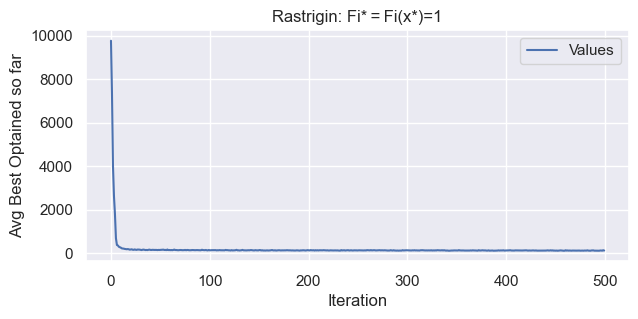

Plot saved as ./report/Griewank.png


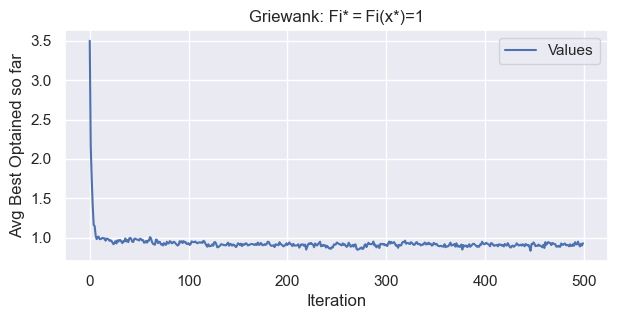

Plot saved as ./report/Ackley.png


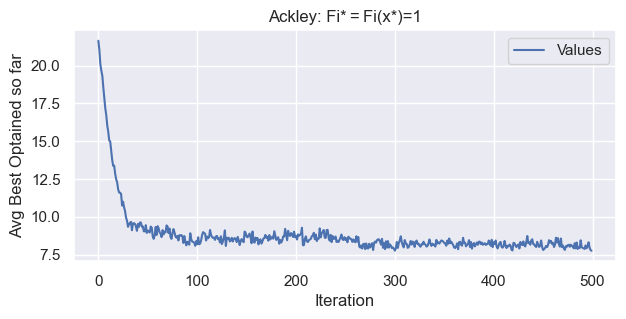

Plot saved as ./report/Happy Cat.png


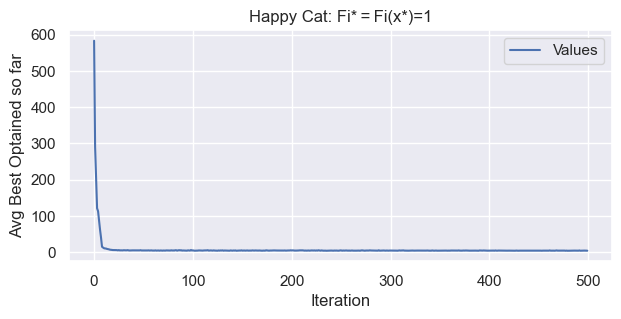

Plot saved as ./report/Expanded Scaffer6.png


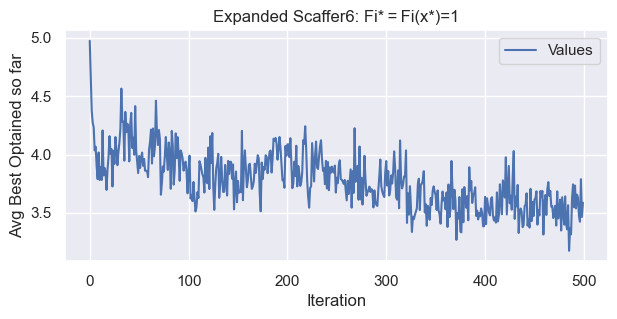

Plot saved as ./report/Weierstrass.png


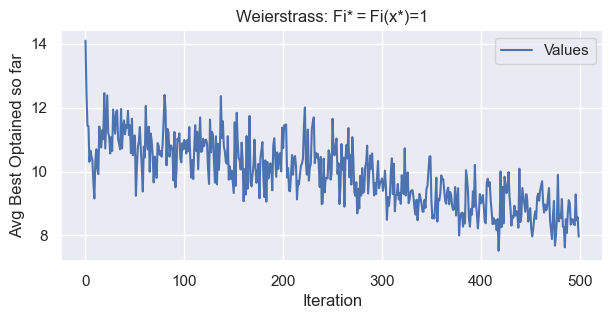

Plot saved as ./report/Schwefel.png


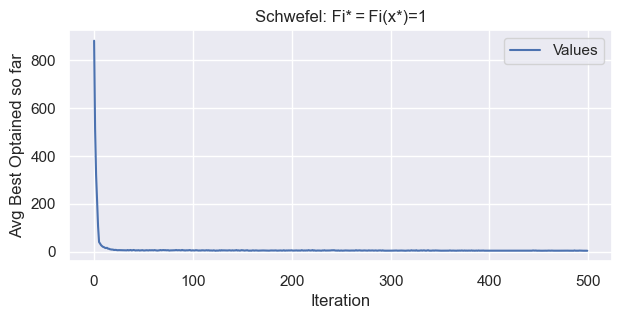

Plot saved as ./report/Lennard_Jones.png


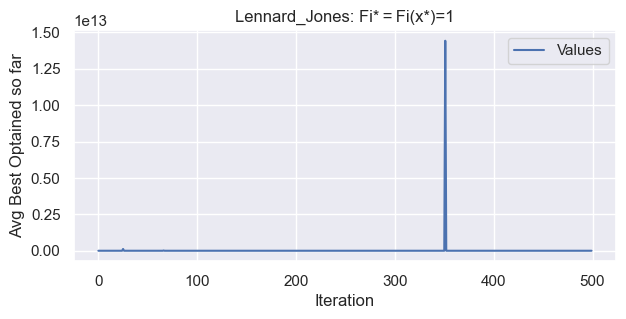

Plot saved as ./report/Hilbert.png


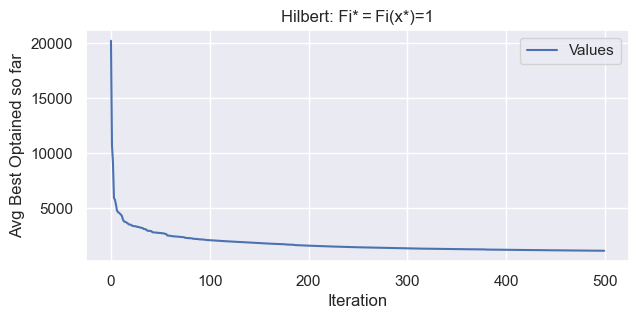

Plot saved as ./report/Chebyshev.png


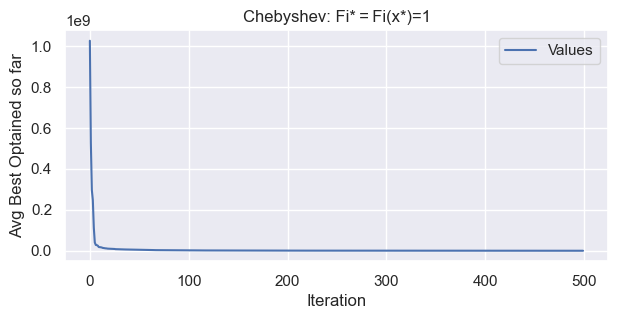

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df_report = pd.DataFrame(da_evals)
df_report[[c for c in df_report.columns if c != "avg_eval_per_iteration"]].to_excel("./report/CEC_functions_WAO_DA_Evaluation_Report_1.xlsx", index=None)

def plot_values_with_seaborn(values, title='My Plot', x_label='X-axis', y_label='Y-axis', save_path=None, highlight_value=None, highlight_color='red'):
    # Check if 'values' is a list, raise an error if not
    if not isinstance(values, list):
        raise ValueError('Values must be a list.')

    # Set the style of seaborn
    sns.set_theme()

    # Prepare the data for plotting
    data = {'Index': list(range(len(values))), 'Values': values}

    # Initialize the matplotlib figure
    plt.figure(figsize=(7, 3))

    # Create a seaborn lineplot
    line = sns.lineplot(data=data, x='Index', y='Values', label='Values')

    # Highlight the specified y-value if provided
    if highlight_value is not None:
        for i, value in enumerate(values):
            if value == highlight_value:
                plt.plot(i, value, color=highlight_color, label='Min Value')

    # Set the title and labels
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Avoiding duplicate labels in the legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    # plt.legend(by_label.values(), by_label.keys())

    # Show grid
    plt.grid(True)

    # Save the plot as an image if a save_path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Plot saved as {save_path}")

    # Show the plot
    plt.show()
for _, row in df_report.iterrows():
    plot_values_with_seaborn(row["avg_eval_per_iteration"].tolist(), title=f'{row["target_function"]}: Fi* = Fi(x*)={row["Fi* = Fi(x*)"]}', x_label='Iteration', y_label='Avg Best Optained so far', save_path=f'./report/{row["target_function"]}.png', highlight_value=row["Best"], highlight_color='red')